In [23]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

### Calculate periodic returns of the portfolio

In [18]:
# Create our portfolio of equities
tickers = ['AAPL', 'C', 'DIS']

# Set the investment weights (I arbitrarily picked for example)
weights = np.array([.35, .25, .4])


# Set an initial investment level
initial_investment = 1000000

# Download closing prices
data = yfinance.download(tickers=tickers, interval='1d', group_by='ticker',
                            auto_adjust=True, threads=True, start="2018-01-01", end=dt.date.today())

df = pd.DataFrame()
df['AAPL'] = data['AAPL'].Close
df['C'] = data['C'].Close
df['DIS'] = data['DIS'].Close

# data = pdr.get_data_yahoo(tickers, start="2018-01-01", end=dt.date.today())['Close']

#From the closing prices, calculate periodic returns
returns = df.pct_change()

returns.tail()

[*********************100%***********************]  3 of 3 completed


,AAPL,C,DIS
Date,,,
2023-04-20,-0.005846,-0.019841,-0.006886
2023-04-21,-0.009781,-0.007490,0.015295
2023-04-24,0.001879,0.000000,0.001105
2023-04-25,-0.009436,-0.023047,-0.016754
2023-04-26,-0.000061,-0.021712,-0.014284


### Create covariance matrix

In [19]:
# Generate Var-Cov matrix
cov_matrix = returns.cov()
cov_matrix

,AAPL,C,DIS
AAPL,0.000431,0.000237,0.000205
C,0.000237,0.000583,0.000298
DIS,0.000205,0.000298,0.000415


### Calculate portfolio mean and standard deviation

In [20]:
# Calculate the portfolio mean and standard deviation
avg_rets = returns.mean()

# Calculate mean returns for portfolio overall
# using dot product to normalise individual means agains investment weights
port_mean = avg_rets.dot(weights)

# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Calculate mean of investment
mean_investment = (1+port_mean)*initial_investment

# Calculate standard deviation of investment
stdev_investment = initial_investment * port_stdev

### Calculate the inverse of the normal cumulative distribution (PPF) with a specified confidence interval, standard deviation, and mean

In [21]:
# Select our confidence interval (95%)
conf_level1 = 0.05

# Using SciPy ppf method to generate values for the inverse cumulative distribution function to a normal distribution
# Pluggin in the mean, standard deviation of our portfolio as calculated abouve
from scipy.stats import norm
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)

### Estimate the value at risk (VaR) for the portfolio by substracting the initial investment from the calculation in step 4

In [22]:
# Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
var_1d1

28653.995707771974

Here we are saying with 95% confidence that our portfolio of 1M USD will not exceed losses greater than 28.6k USD over a one day period.

### Value at risk over n-day time period

1 day VaR @ 95% confidence: 28654.0
2 day VaR @ 95% confidence: 40522.87
3 day VaR @ 95% confidence: 49630.18
4 day VaR @ 95% confidence: 57307.99
5 day VaR @ 95% confidence: 64072.28
6 day VaR @ 95% confidence: 70187.67
7 day VaR @ 95% confidence: 75811.35
8 day VaR @ 95% confidence: 81045.74
9 day VaR @ 95% confidence: 85961.99
10 day VaR @ 95% confidence: 90611.89
11 day VaR @ 95% confidence: 95034.55
12 day VaR @ 95% confidence: 99260.35
13 day VaR @ 95% confidence: 103313.45
14 day VaR @ 95% confidence: 107213.43
15 day VaR @ 95% confidence: 110976.45


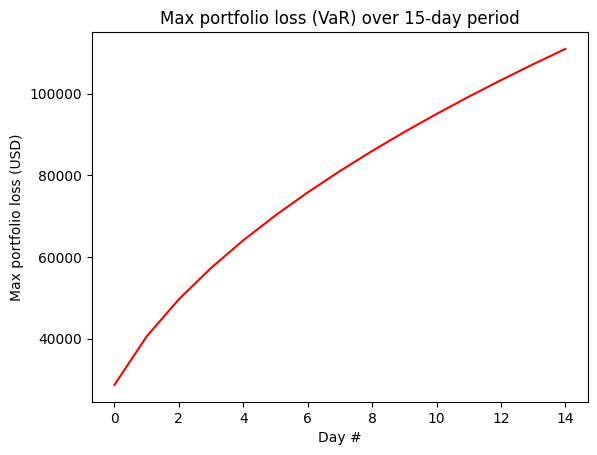

In [24]:
# Calculate n Day VaR
var_array = []
num_days = int(15)
for x in range(1, num_days+1):
    var_array.append(np.round(var_1d1*np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")

### Checking distributions of our equities against normal distribution

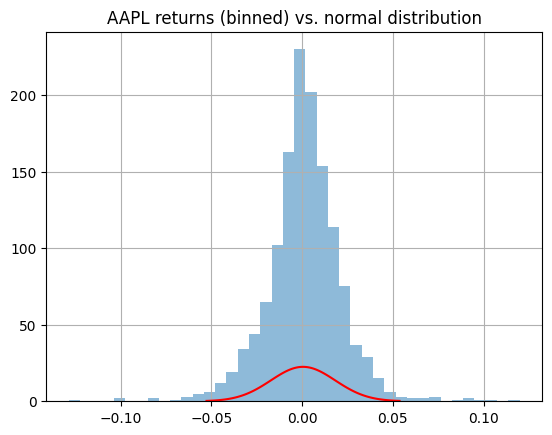

In [49]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Repeat for each equity in portfolio
returns['AAPL'].hist(bins=40,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, norm.pdf(x, port_mean, port_stdev), "r")
plt.title("AAPL returns (binned) vs. normal distribution")
plt.show()